# Covid forcast

This notebook forecasts dates at wich critical limits in infection rates are reached for European countries

Do all imports in inits

In [1]:
import pandas as pd
import numpy as np
import requests
import io
from datetime import datetime
import plotly.graph_objs as go
import plotly.offline as py
import math

data_x = np.array([0,1,2])


Define some functions

In [2]:

def fit_inc(row):
    data_y = np.log(np.array([row['seven_inc2'], row['seven_inc1'], row['seven_inc']]))
    try:
        curve_fit = np.polyfit(data_x, data_y, 1)
        
        days_50 = -(curve_fit[1]-math.log(50.0))/curve_fit[0]
        curve_fit = np.append(curve_fit, days_50)
    except Exception as e:
        
        return [np.NaN, np.NaN, np.NaN]
    return curve_fit


def extend_country(country_data):

    country_data_avg = country_data['cases'].rolling(window=7,min_periods=7).sum()[6:]/country_data['popData2020'].values[0]*100000
    
    country_data_avg.name= 'seven_inc'

    country_data_avg = pd.DataFrame(country_data_avg, columns=['seven_inc'])
    country_data_avg = country_data_avg.append(pd.DataFrame([np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN], columns=['seven_inc']),ignore_index=True)

#    print(country_data_avg.head(5))

    country_data = pd.concat([country_data.reset_index(), country_data_avg], axis=1)

    country_data['seven_inc1'] = country_data.seven_inc.shift(-1)
    country_data['seven_inc2'] = country_data.seven_inc.shift(-2)

    country_data_fit = country_data.apply(lambda row: fit_inc(row), axis=1, result_type='expand')
    country_data_fit.columns = ['fit_exponent', 'fit_factor', 'days_50']

    country_data = pd.concat([country_data.reset_index(), country_data_fit], axis=1)
    country_data_fit['days_double'] = country_data.fit_exponent.apply(lambda x: np.log(2)/x)
    
    return country_data_fit

   



Get dataset from ECDC

In [3]:
mydateparser = lambda x: datetime.strptime(x, "%d/%m/%Y")

url = 'https://opendata.ecdc.europa.eu/covid19/nationalcasedeath_eueea_daily_ei/csv/data.csv'


s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')), parse_dates=['dateRep'], date_parser=mydateparser)


In [4]:
countries = c['countryterritoryCode'].unique().tolist()
print(countries)

['AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'ISL', 'IRL', 'ITA', 'LVA', 'LIE', 'LTU', 'LUX', 'MLT', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE']


In [5]:

cols = ['dateRep', 'countriesAndTerritories', 'cases', 'days_50', 'days_double']

summary = pd.DataFrame(columns = cols)
country_data = {}


for country in countries:
    country_data[country] = c[c['countryterritoryCode'] == country]
    fit = extend_country(country_data[country])
        
    country_data[country] = pd.concat([country_data[country].reset_index(), fit], axis=1)
    
    summary = summary.append(country_data[country][cols].head(1))


/tmp/ipykernel_78/3192500101.py:6: RuntimeWarning:

divide by zero encountered in double_scalars



Show result (summary)

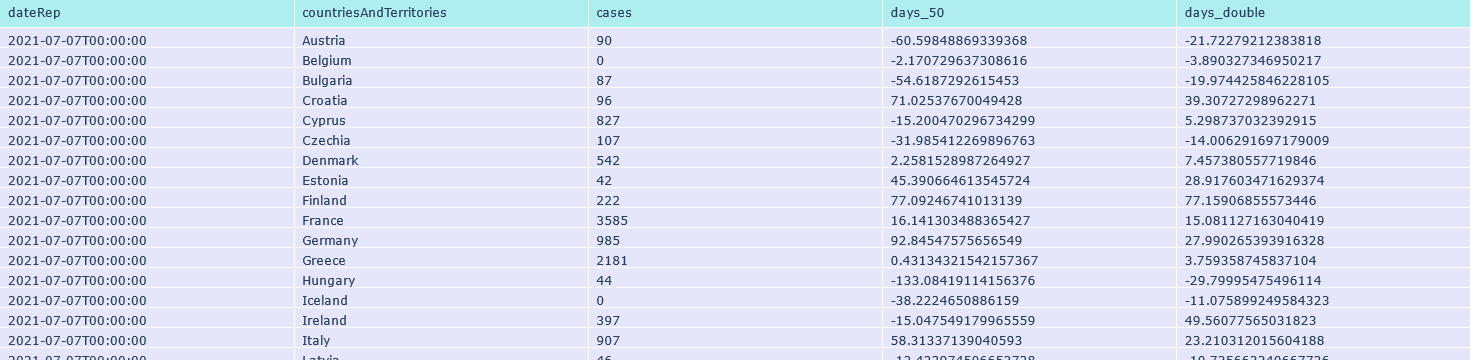

In [6]:
fig = go.Figure(data=[go.Table(
        header=dict(values=list(summary.columns),
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=summary.transpose().values.tolist(),
                   fill_color='lavender',
                   align='left'))
    ])
    
fig.update_layout(margin=dict(t=0,b=0,l=0,r=0))
fig.show()

Show days to 50 infections / 100.000 inhabitants
- Negative values mean: rate of infections decreasing / value currently above 50
- Positive values mean: rate of infections increasing / value currently below 50

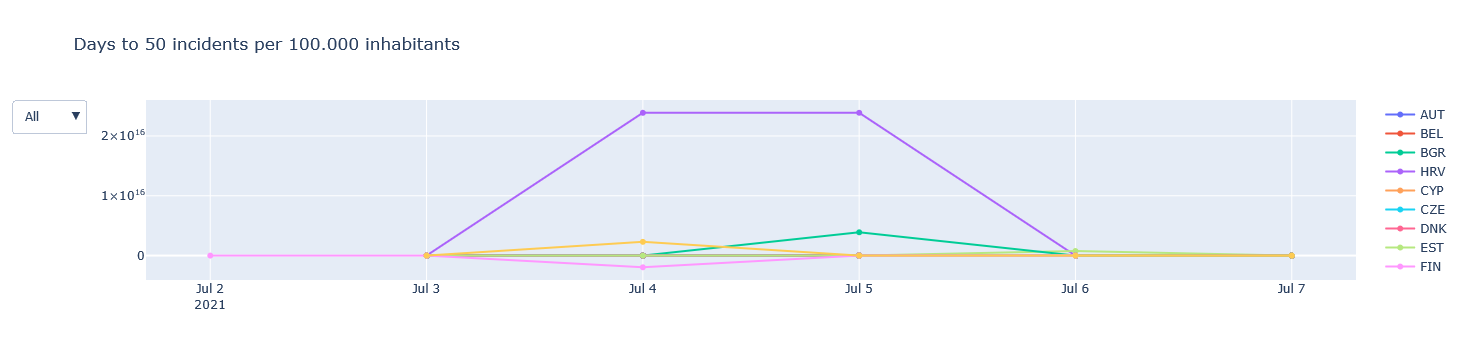

In [7]:
fig = go.Figure()


for country in countries:
    fig.add_trace(
        go.Scatter(x = country_data[country].dateRep[:5], y = country_data[country].days_50[:5], name = country)
    )
    
    
button_all = dict(label = 'All',
                      method = 'update',
                      args = [{'visible': list(map(lambda x: True, countries)),
                               'title': 'All',
                               'showlegend':True}])


def create_layout_button(column):
    return dict(label = column,
                method = 'update',
                args = [{'visible': list(map(lambda x: column == x, countries)),
                         'title': column,
                         'showlegend': True}])

fig.update_layout(
    title=dict(text='Days to 50 incidents per 100.000 inhabitants'),
    updatemenus=[go.layout.Updatemenu(
        active = 0,
        buttons = ([button_all] ) + list(map(lambda column: create_layout_button(column), countries))
        )
    ])
    
